## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.utils.platform import get_file_size, get_num_workers

from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.deeplabv3 import DeepLabV3
from torchlake.semantic_segmentation.models.deeplabv2 import deeplab_v2_style_resnet

from tqdm import tqdm

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/deeplabv3")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 4
TRAIN_IMAGE_SIZE = 321 # 32k-31
TEST_IMAGE_SIZE = 513 # 32k-31
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
train_transform = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(TRAIN_IMAGE_SIZE, TRAIN_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.Resize(TEST_IMAGE_SIZE, TEST_IMAGE_SIZE),
        A.Normalize(0, 1),  # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=train_transform,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_transform,
)

In [7]:
NUM_WORKERS = get_num_workers()

In [8]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
    num_workers=NUM_WORKERS,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE // 2,
    num_workers=NUM_WORKERS,
)

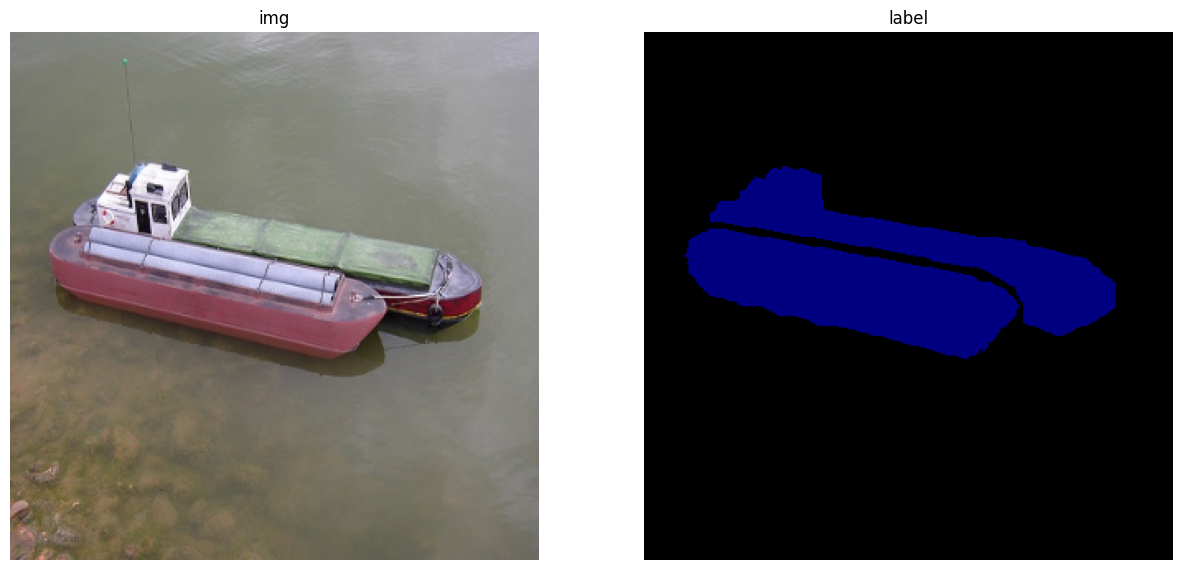

In [9]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

In [10]:
row = next(iter(train_loader))
for ele in row: print(ele.shape)

torch.Size([4, 3, 321, 321])
torch.Size([4, 321, 321])


# model

In [11]:
backbone = deeplab_v2_style_resnet("resnet101", trainable=True)
model = DeepLabV3(
    backbone,
    output_size=NUM_CLASS + 1,
    dilations=(8, 16, 1),
    neck_type="cascade",
).to(DEVICE)

In [12]:
torchinfo.summary(model)

Layer (type:depth-idx)                                            Param #
DeepLabV3                                                         --
├─ResNetFeatureExtractor: 1-1                                     --
│    └─Sequential: 2-1                                            --
│    │    └─Conv2d: 3-1                                           9,408
│    │    └─BatchNorm2d: 3-2                                      128
│    │    └─ReLU: 3-3                                             --
│    │    └─MaxPool2d: 3-4                                        --
│    │    └─Sequential: 3-5                                       215,808
│    │    └─Sequential: 3-6                                       1,219,584
│    │    └─Sequential: 3-7                                       26,090,496
│    │    └─Sequential: 3-8                                       14,964,736
│    └─ImageNetNormalization: 2-2                                 --
├─Sequential: 1-2                                                 

# train

In [14]:
EPOCHS = 30

In [16]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [18]:
criterion = trainer.get_criterion(NUM_CLASS)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [19]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, threshold=.05 ,threshold_mode ='rel')

In [20]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [04:32<00:00,  1.34it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.0648e-01 (0.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 2
------------------------------------
total: 5.1275e-02 (-52.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 3
------------------------------------
total: 3.7681e-02 (-27.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 4
------------------------------------
total: 2.8675e-02 (-24.00%)


100%|██████████| 364/364 [03:03<00:00,  1.99it/s]


------------------------------------
Epoch 5
------------------------------------
total: 2.4874e-02 (-13.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 6
------------------------------------
total: 2.0938e-02 (-16.00%)


100%|██████████| 364/364 [03:03<00:00,  1.99it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.9240e-02 (-8.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.6010e-02 (-17.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.6378e-02 (2.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.4979e-02 (-9.00%)


100%|██████████| 364/364 [03:15<00:00,  1.86it/s]


------------------------------------
Epoch 11
------------------------------------
total: 1.2228e-02 (-18.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 12
------------------------------------
total: 1.3580e-02 (11.00%)


100%|██████████| 364/364 [03:02<00:00,  2.00it/s]


------------------------------------
Epoch 13
------------------------------------
total: 1.3970e-02 (3.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 14
------------------------------------
total: 1.2872e-02 (-8.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 15
------------------------------------
total: 1.2527e-02 (-3.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 16
------------------------------------
total: 1.2537e-02 (0.00%)


100%|██████████| 364/364 [03:02<00:00,  2.00it/s]


------------------------------------
Epoch 17
------------------------------------
total: 1.1452e-02 (-9.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 18
------------------------------------
total: 1.0013e-02 (-13.00%)


100%|██████████| 364/364 [03:10<00:00,  1.91it/s]


------------------------------------
Epoch 19
------------------------------------
total: 9.1202e-03 (-9.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 20
------------------------------------
total: 8.0235e-03 (-12.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 21
------------------------------------
total: 8.8484e-03 (10.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 22
------------------------------------
total: 1.1425e-02 (29.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 23
------------------------------------
total: 1.1062e-02 (-3.00%)


100%|██████████| 364/364 [04:09<00:00,  1.46it/s]


------------------------------------
Epoch 24
------------------------------------
total: 9.8265e-03 (-11.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 25
------------------------------------
total: 9.8132e-03 (0.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 26
------------------------------------
total: 8.1897e-03 (-17.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 27
------------------------------------
total: 7.1937e-03 (-12.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 28
------------------------------------
total: 6.8731e-03 (-4.00%)


100%|██████████| 364/364 [03:02<00:00,  2.00it/s]


------------------------------------
Epoch 29
------------------------------------
total: 6.7155e-03 (-2.00%)


100%|██████████| 364/364 [03:14<00:00,  1.87it/s]

------------------------------------
Epoch 30
------------------------------------
total: 6.5790e-03 (-2.00%)


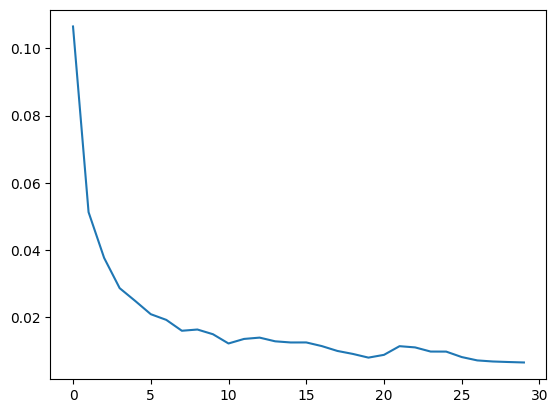

In [21]:
plt.plot(training_loss)

In [13]:
wm = WeightManager(artifacts_path.joinpath('deeplabv3.resnet101.{aspp_mode}.pth').as_posix())

In [14]:
model_path = wm.get_filename(aspp_mode=model.neck_type)
model_path

WindowsPath('../../artifacts/deeplabv3/deeplabv3.resnet101.cascade.pth')

In [35]:
torch.save(model.state_dict(), model_path)

In [36]:
get_file_size(model_path)

'318.26MiB'

In [15]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# inference

### dice coef

In [16]:
from torchmetrics.classification import jaccard

metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [17]:
evaluator = ClassificationEvaluator(NUM_CLASS+1, DEVICE)

In [18]:
metric = evaluator.run(test_loader, model, metric)

  0%|          | 0/316 [00:00<?, ?it/s]

100%|██████████| 316/316 [00:44<00:00,  7.10it/s]


In [19]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.88 
bicycle        : 0.61 
bird           : 0.91 
boat           : 0.83 
bottle         : 0.85 
bus            : 0.86 
car            : 0.84 
cat            : 0.9  
chair          : 0.62 
cow            : 0.86 
diningtable    : 0.81 
dog            : 0.85 
horse          : 0.79 
motorbike      : 0.75 
person         : 0.87 
pottedplant    : 0.64 
sheep          : 0.84 
sofa           : 0.67 
train          : 0.86 
tvmonitor      : 0.86 
----------------------
total          : 0.8  


(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

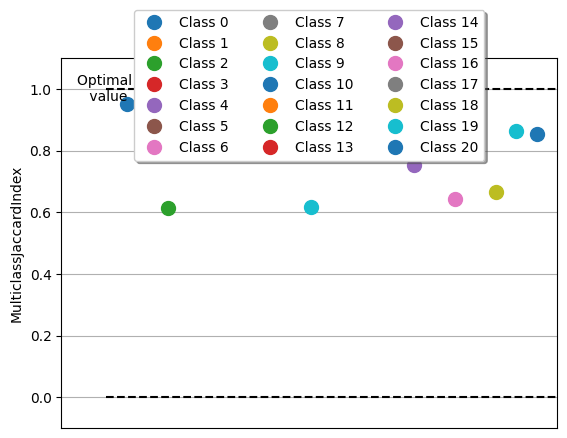

In [26]:
metric.plot()

### for image in dataset

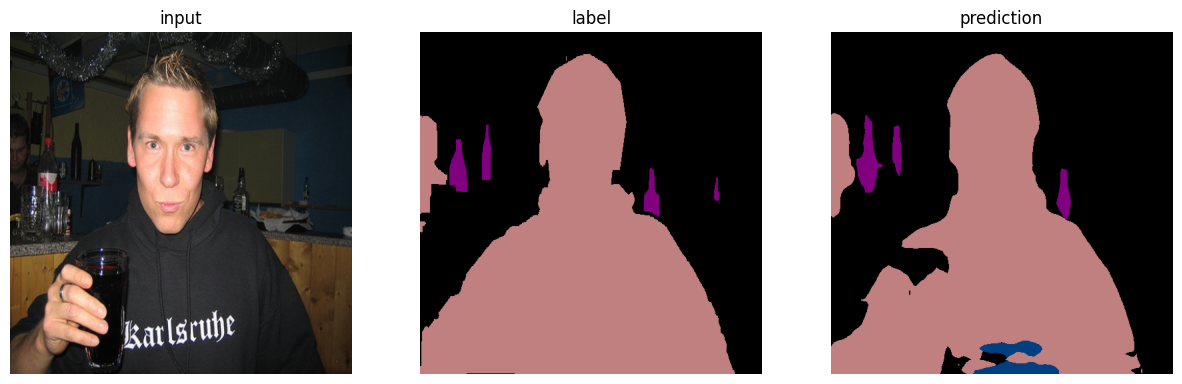

In [27]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

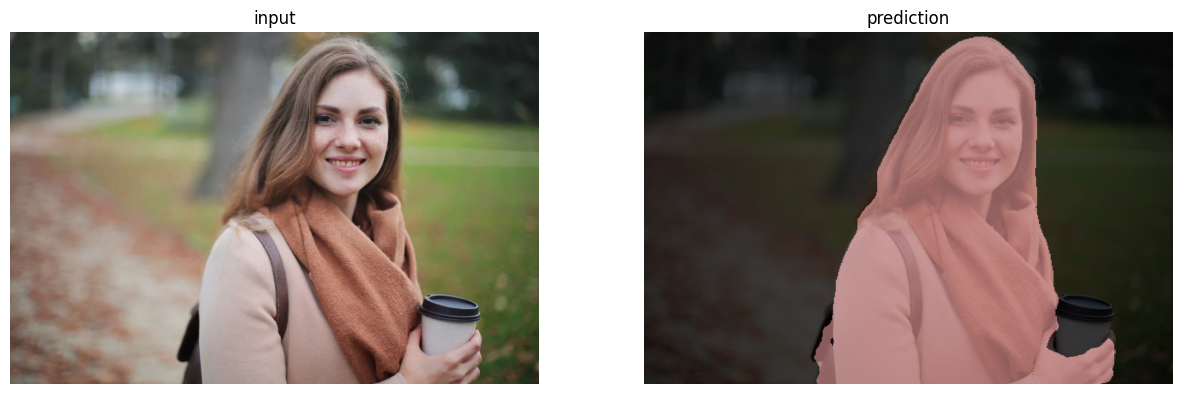

In [28]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_transform(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )